# Init

In [1]:
%cd ..

import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict
import os

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    'font.size': 12,
})


def plot_psnr_analysis(resolution, snr=30, seeds=[42], types=["linear", "mlp", "conv", "twoconv", "zeroshot"]):

    type_name_dict = {
        "linear": "Linear",
        "mlp": "MLP",
        "conv": "single-layer CNN",
        "twoconv": "2-layer CNN.",
        "zeroshot": "PFE"
    }
    
    aligner_data = defaultdict(lambda: defaultdict(list))
    
    unaligned_values = []
    aligned_values = []
    zeroshot_values = []
    
    # process each seed
    for seed in seeds:
        # read baseline values for this seed
        lines_path = f'alignment/logs_{resolution}/lines_snr_{snr}_seed_{seed}.txt'
        
        if os.path.exists(lines_path):
            with open(lines_path, 'r') as file:
                lines = file.readlines()
                unaligned_values.append(float(lines[0].split()[1]))
                aligned_values.append(float(lines[1].split()[1]))
                zeroshot_values.append(float(lines[2].split()[1]))

        else:
            print(f"Warning: {lines_path} not found, skipping seed {seed}")
            continue
        
        # process each aligner type for this seed
        for aligner_type in types:
            log_path = f'alignment/logs_{resolution}/aligner_{aligner_type}_snr_{snr}_seed_{seed}.txt'
            
            if os.path.exists(log_path):
                with open(log_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                
                # extract sample counts and PSNR values
                matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', content)
                
                for sample_str, psnr_str in matches:
                    sample_count = int(sample_str)
                    psnr_value = float(psnr_str)
                    aligner_data[aligner_type][sample_count].append(psnr_value)

            else:
                print(f"Warning: {log_path} not found")
    
    # calculate means for baseline values
    unaligned_mean = np.mean(unaligned_values) if unaligned_values else 0
    aligned_mean = np.mean(aligned_values) if aligned_values else 0
    zeroshot_mean = np.mean(zeroshot_values) if zeroshot_values else 0
    
    # create the plot
    plt.figure(figsize=(8, 6))
    
    # plot each aligner type
    for aligner_type in types:
        if aligner_type in aligner_data:
            # get all sample counts and sort them
            sample_counts = sorted(aligner_data[aligner_type].keys())
            mean_psnr = []
            std_psnr = []
            
            for sample_count in sample_counts:
                psnr_values = aligner_data[aligner_type][sample_count]
                mean_psnr.append(np.mean(psnr_values))
                std_psnr.append(np.std(psnr_values))
            
            # convert to numpy arrays for easier manipulation
            sample_counts = np.array(sample_counts)
            mean_psnr = np.array(mean_psnr)
            std_psnr = np.array(std_psnr)
            
            # plot mean line
            line = plt.plot(sample_counts, mean_psnr, marker='o', label=f'{type_name_dict[aligner_type]}')[0]
            
            # fill area representing standard deviation
            plt.fill_between(sample_counts, 
                           mean_psnr - std_psnr, 
                           mean_psnr + std_psnr, 
                           alpha=0.2, 
                           color=line.get_color())
    
    # plot baseline horizontal lines
    if unaligned_values:
        plt.axhline(y=unaligned_mean, color='red', linestyle='--', linewidth=1, 
                   label=f'Unaligned')
    if aligned_values:
        plt.axhline(y=aligned_mean, color='green', linestyle='--', linewidth=1, 
                   label=f'No mismatch')
    if zeroshot_values:
        plt.axhline(y=zeroshot_mean, color='blue', linestyle='--', linewidth=1, 
                   label=f'PFE Full')
    
    # plt.title(f"SNR {snr} - Resolution {resolution}x{resolution} - Mean across {len(seeds)} seeds")
    plt.xlabel("Number of Semantic Pilots", fontsize=16)
    plt.ylabel("PSNR (dB)", fontsize=16)
    plt.xscale('log')
    plt.tick_params(axis='both', labelsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    os.makedirs('output', exist_ok=True)
    
    filename = f"psnr_vs_pilots_snr_{snr}"
    
    # save in both formats
    pdf_path = os.path.join('output', f"{filename}.pdf")
    png_path = os.path.join('output', f"{filename}.png")
    
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    
    print(f"Plots saved as:")
    print(f"  PDF: {pdf_path}")
    print(f"  PNG: {png_path}")

    plt.show()


def plot_psnr_vs_snr_analysis(resolution, snr_ae=-10, snr_values=[-20, -10, 0, 10, 20, 30], seeds=[42, 43, 44, 45, 46],
                              types=["linear", "mlp", "conv", "twoconv", "zeroshot"],
                              target_sample_count=10000):

    type_name_dict = {
        "linear": "Linear",
        "conv": "single-layer CNN",
        "twoconv": "2-layer CNN",
        "zeroshot": "PFE"
    }
    
    aligner_data = defaultdict(lambda: defaultdict(list))  # {methodology: {snr: [psnr_values]}}
    
    # dictionary to store baseline values across SNR values
    baseline_data = {
        'unaligned': defaultdict(list),
        'aligned': defaultdict(list),
        'zeroshot_baseline': defaultdict(list)
    }
    
    # process each SNR value
    for snr in snr_values:
        # Process each seed
        for seed in seeds:
            # read baseline values for this SNR and seed
            lines_path = f'alignment/logs_{resolution}/lines_ae_{snr_ae}_snr_{snr}_seed_{seed}.txt'
            
            if os.path.exists(lines_path):
                with open(lines_path, 'r') as file:
                    lines = file.readlines()
                    baseline_data['unaligned'][snr].append(float(lines[0].split()[1]))
                    baseline_data['aligned'][snr].append(float(lines[1].split()[1]))
                    baseline_data['zeroshot_baseline'][snr].append(float(lines[2].split()[1]))
            else:
                print(f"Warning: {lines_path} not found, skipping SNR {snr}, seed {seed}")
                continue
            
            # process each aligner type for this SNR and seed
            for aligner_type in types:
                log_path = f'alignment/logs_{resolution}/aligner_{aligner_type}_ae_{snr_ae}_snr_{snr}_seed_{seed}.txt'
                
                if os.path.exists(log_path):
                    with open(log_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                    
                    # extract sample counts and PSNR values
                    matches = re.findall(r'got a PSNR of ([\d.]+)', content)
                    
                    if matches:
                        # if target_sample_count is specified, find that specific count
                        for psnr_str in matches:
                            aligner_data[aligner_type][snr].append(float(psnr_str))

                else:
                    print(f"Warning: {log_path} not found")
    
    # create the plot
    plt.figure(figsize=(8, 6))

    # plot baseline lines
    baseline_labels = {
        'unaligned': 'Unaligned',
        'aligned': 'No Mismatch', 
        'zeroshot_baseline': 'PFE Full'
    }
    
    baseline_colors = {
        'unaligned': 'red',
        'aligned': 'green',
        'zeroshot_baseline': 'blue'
    }
    
    for baseline_name, baseline_values in baseline_data.items():
        if baseline_name == "unaligned":
            continue

        snr_list = []
        mean_psnr = []
        std_psnr = []
        
        for snr in sorted(baseline_values.keys()):
            psnr_values = baseline_values[snr]
            if psnr_values:
                snr_list.append(snr)
                mean_psnr.append(np.mean(psnr_values))
                std_psnr.append(np.std(psnr_values))
        
        if snr_list:
            snr_array = np.array(snr_list)
            mean_psnr = np.array(mean_psnr)
            std_psnr = np.array(std_psnr)
            
            if baseline_name == "aligned":

                line = plt.plot(snr_array, mean_psnr, 
                            color=baseline_colors[baseline_name], 
                            linestyle='--',
                            linewidth=2,
                            marker='s', markersize=4,
                            label=baseline_labels[baseline_name])[0]
                
            else:
                line = plt.plot(snr_array, mean_psnr, marker='o', 
                               label=baseline_labels[baseline_name])[0]
            
            plt.fill_between(snr_array, 
                           mean_psnr - std_psnr, 
                           mean_psnr + std_psnr, 
                           alpha=0.1, 
                           color=baseline_colors[baseline_name])
    
    # plot each aligner type
    for aligner_type in types:
        if aligner_type in aligner_data:
            snr_list = []
            mean_psnr = []
            std_psnr = []
            
            for snr in sorted(aligner_data[aligner_type].keys()):
                psnr_values = aligner_data[aligner_type][snr]
                if psnr_values:  # Only include SNR values that have data
                    snr_list.append(snr)
                    mean_psnr.append(np.mean(psnr_values))
                    std_psnr.append(np.std(psnr_values))
            
            if snr_list:  # Only plot if we have data
                # Convert to numpy arrays
                snr_array = np.array(snr_list)
                mean_psnr = np.array(mean_psnr)
                std_psnr = np.array(std_psnr)
                
                # Plot mean line
                line = plt.plot(snr_array, mean_psnr, marker='o', 
                               label=f'{type_name_dict[aligner_type]}')[0]
                
                # Fill area representing standard deviation
                plt.fill_between(snr_array, 
                               mean_psnr - std_psnr, 
                               mean_psnr + std_psnr, 
                               alpha=0.2, 
                               color=line.get_color())
    
    # formatting
    sample_info = f" (at {target_sample_count} samples)" if target_sample_count else " (max samples)"
    # plt.title(f"PSNR vs SNR - Resolution {resolution}x{resolution}{sample_info} - Mean across {len(seeds)} seeds")
    plt.xlabel("SNR (dB)", fontsize=16)
    plt.ylabel("PSNR (dB)", fontsize=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # save the plot
    os.makedirs('output', exist_ok=True)
    
    sample_suffix = f"_samples_{target_sample_count}" if target_sample_count else "_max_samples"
    filename = f"psnr_vs_snr_{snr_ae}{sample_suffix}"
    
    # Save in both formats
    pdf_path = os.path.join('output', f"{filename}.pdf")
    png_path = os.path.join('output', f"{filename}.png")
    
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    
    print(f"Plots saved as:")
    print(f"  PDF: {pdf_path}")
    print(f"  PNG: {png_path}")

    plt.show()

/home/lorenzo/repos/Deep-JSCC-PyTorch


# Exec

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_30.pdf
  PNG: output/psnr_vs_pilots_snr_30.png


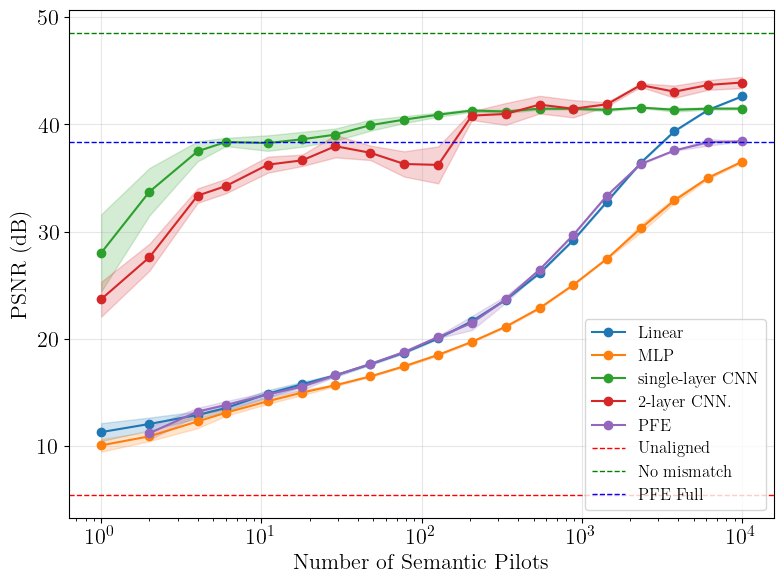

In [2]:
plot_psnr_analysis(resolution=96, snr=30, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_20.pdf
  PNG: output/psnr_vs_pilots_snr_20.png


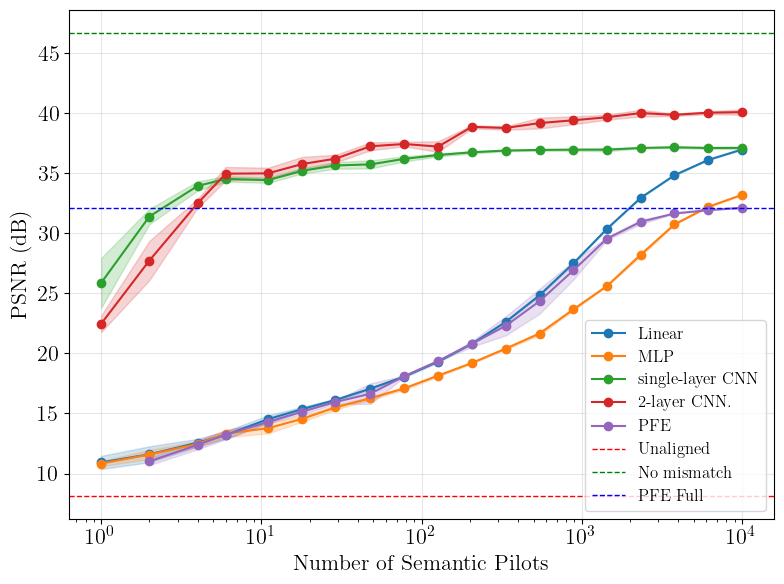

In [3]:
plot_psnr_analysis(resolution=96, snr=20, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_10.pdf
  PNG: output/psnr_vs_pilots_snr_10.png


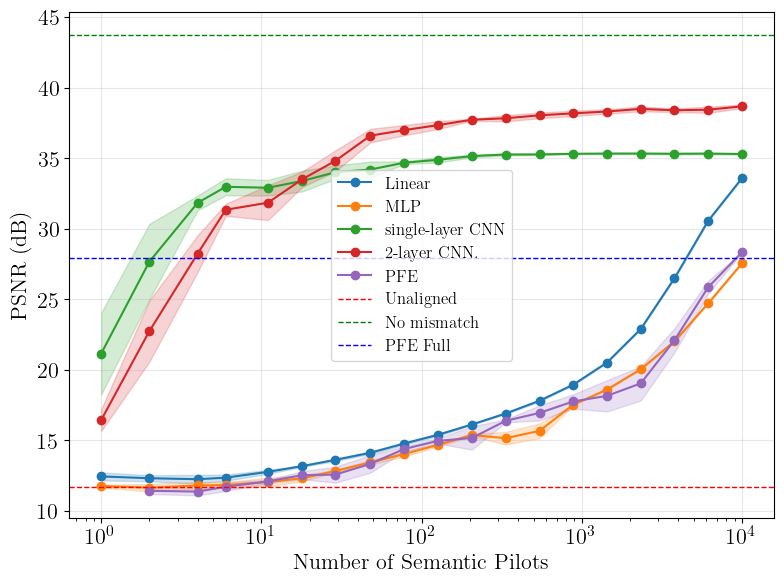

In [4]:
plot_psnr_analysis(resolution=96, snr=10, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_0.pdf
  PNG: output/psnr_vs_pilots_snr_0.png


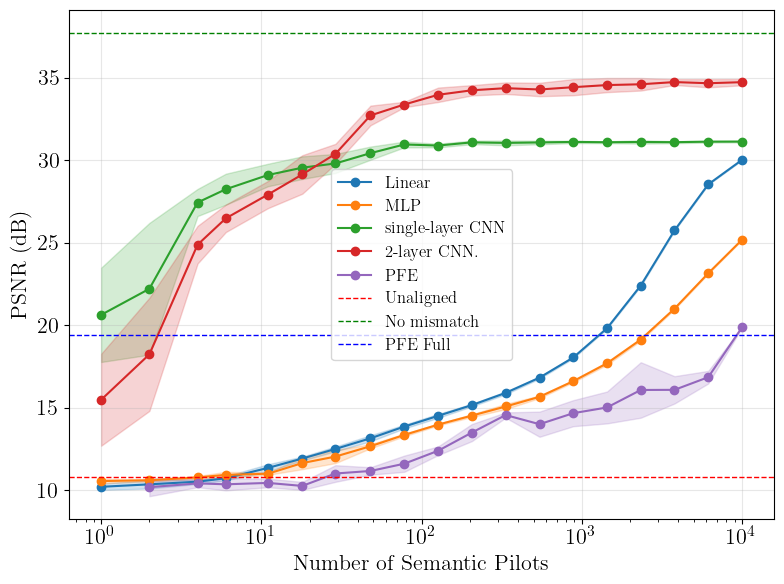

In [5]:
plot_psnr_analysis(resolution=96, snr=0, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_-10.pdf
  PNG: output/psnr_vs_pilots_snr_-10.png


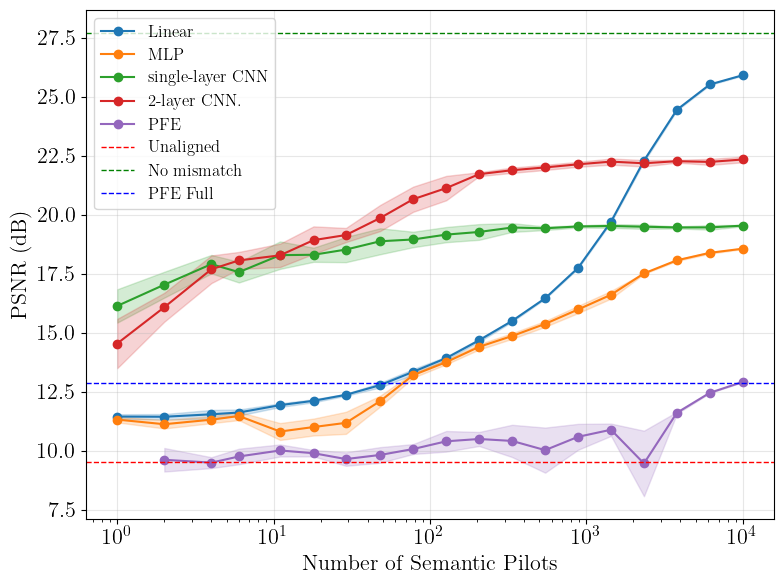

In [6]:
plot_psnr_analysis(resolution=96, snr=-10, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_pilots_snr_-20.pdf
  PNG: output/psnr_vs_pilots_snr_-20.png


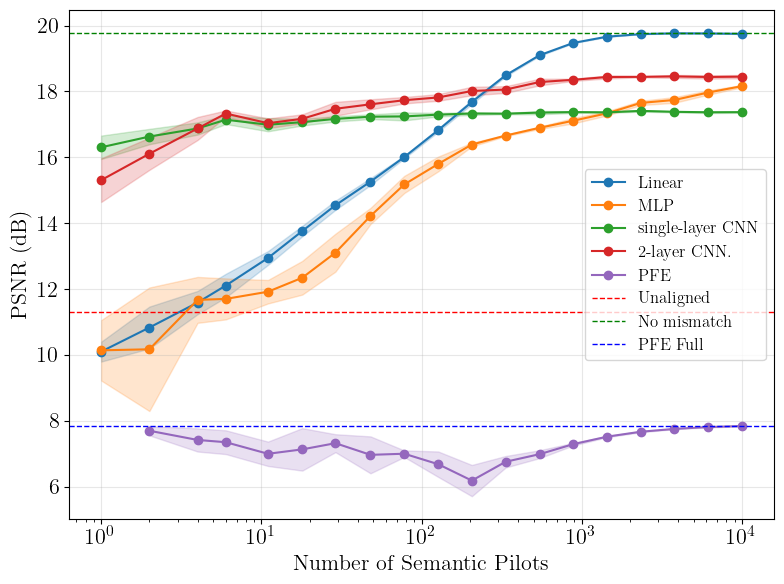

In [7]:
plot_psnr_analysis(resolution=96, snr=-20, seeds=[42, 43, 44, 45, 46])

Plots saved as:
  PDF: output/psnr_vs_snr_-10_samples_10000.pdf
  PNG: output/psnr_vs_snr_-10_samples_10000.png


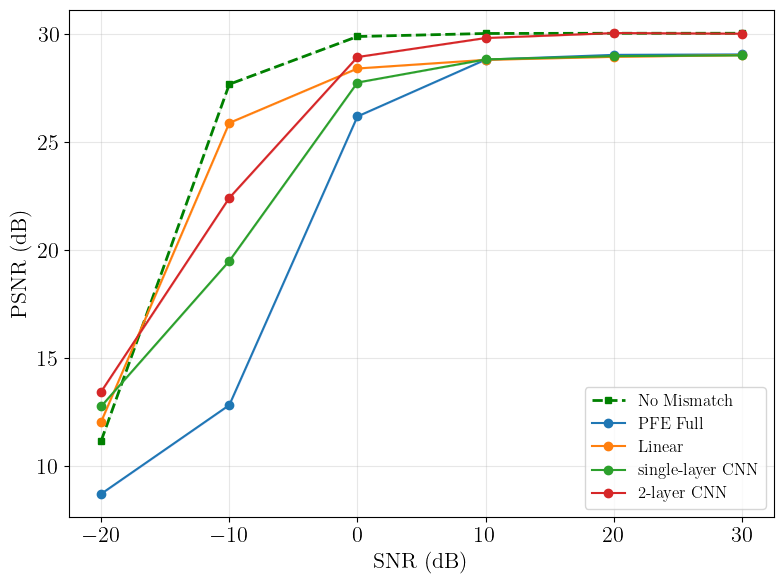

In [8]:
plot_psnr_vs_snr_analysis(resolution=96, snr_ae=-10, target_sample_count=10000, seeds=[42],
                          types=["linear", "conv", "twoconv"],
                          snr_values=[-20, -10, 0, 10, 20, 30])

Plots saved as:
  PDF: output/psnr_vs_snr_20_samples_10000.pdf
  PNG: output/psnr_vs_snr_20_samples_10000.png


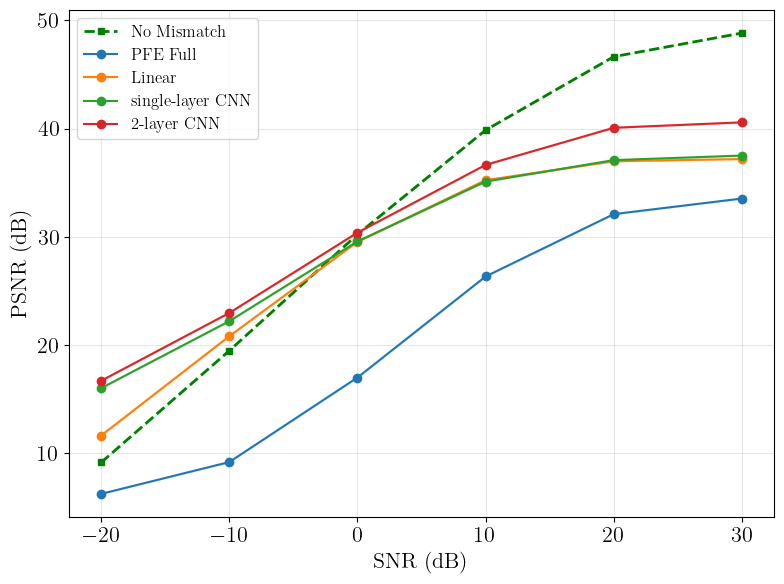

In [9]:
plot_psnr_vs_snr_analysis(resolution=96, snr_ae=20, target_sample_count=10000, seeds=[42],
                          types=["linear", "conv", "twoconv"],
                          snr_values=[-20, -10, 0, 10, 20, 30])